## April Code pudding Project (Youtube Sentiment Analysis)

This project focuses on analyzing the relationship between YouTube comment sentiment and like-to-dislike ratios. The goal is to determine whether viewer sentiment expressed through comments aligns with engagement metrics provided by the platform. The analysis includes natural language processing techniques, exploratory data analysis, and supervised machine learning to classify comment sentiment as positive or negative.

A sentiment classification model will be trained and applied to a dataset of YouTube comments. The results will then be compared to like-to-dislike ratios to assess any discrepancies or patterns. Specific case studies will highlight instances where the comment sentiment diverges from the like/dislike ratio, providing insight into viewer behavior and platform dynamics.

This project is a collaborative effort, and the repository serves as the central space for development, data, and results.

### Importing and loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

import xgboost as xgb
from textblob import TextBlob

from tqdm import tqdm

In [2]:
dataset_path = os.path.join('..', 'datasets', 'archive')

comments = pd.read_csv(
    os.path.join(dataset_path, 'UScomments.csv'),
    on_bad_lines='skip',
    encoding='utf-8',
    low_memory=False
)
videos = pd.read_csv(
    os.path.join(dataset_path, 'USvideos.csv'), 
    on_bad_lines='skip', 
    encoding='utf-8')

In [3]:
comments.head()

,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [4]:
videos.head(10)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,13.09
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,13.09
5,cMKX2tE5Luk,The Disaster Artist | Official Trailer HD | A24,A24,1,a24|a24 films|a24 trailers|independent films|t...,1311445,34507,544,3040,https://i.ytimg.com/vi/cMKX2tE5Luk/default.jpg,13.09
6,8wNr-NQImFg,"The Check In: HUD, Ben Carson and Hurricanes",Late Night with Seth Meyers,23,Late night|Seth Meyers|check in|hud|Ben Carson...,666169,9985,297,1071,https://i.ytimg.com/vi/8wNr-NQImFg/default.jpg,13.09
7,_HTXMhKWqnA,iPhone X Impressions & Hands On!,Marques Brownlee,28,iPhone X|iphone x|iphone 10|iPhone X impressio...,1728614,74062,2180,15297,https://i.ytimg.com/vi/_HTXMhKWqnA/default.jpg,13.09
8,_ANP3HR1jsM,ATTACKED BY A POLICE DOG!!,RomanAtwoodVlogs,22,Roman Atwood|Roman|Atwood|roman atwood vlogs|f...,1338533,69687,678,5643,https://i.ytimg.com/vi/_ANP3HR1jsM/default.jpg,13.09
9,zgLtEob6X-Q,Honest Trailers - The Mummy (2017),Screen Junkies,1,screenjunkies|screen junkies|screenjunkies new...,1056891,29943,878,4046,https://i.ytimg.com/vi/zgLtEob6X-Q/default.jpg,13.09


### Comments

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/betaknight/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/betaknight/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This function prepares text for analysis by cleaning and simplifying it. First, it downloads necessary language tools that help break text into words and remove common words that do not carry meaning. A list of common English words like "the", "is", and "and" is stored so they can be filtered out.

When the function is used on a comment:
1. The entire comment is changed to lowercase so that words like "Logan" and "logan" are treated the same.
2. Any links starting with "http" are removed from the comment.
3. All characters that are not letters or spaces are removed, including punctuation and numbers.
4. The remaining words are split into a list.
5. Each word is checked, and any word that is too common or not useful for analysis is removed.
6. The cleaned words are combined back into one string for further analysis.

In [6]:
comments['clean_text'] = comments['comment_text'].astype(str).apply(clean_text)
comments = comments.drop(columns=['comment_text'])

comments.head()

,video_id,likes,replies,clean_text
0,XpVt6Z1Gjjo,4,0,logan paul yo big day
1,XpVt6Z1Gjjo,3,0,ive following start vine channel seen vlogs
2,XpVt6Z1Gjjo,3,0,say hi kong maverick
3,XpVt6Z1Gjjo,3,0,fan attendance
4,XpVt6Z1Gjjo,3,0,trending


### Videos

In [7]:
videos['like_dislike_ratio'] = videos['likes'] / (videos['likes'] + videos['dislikes'])
videos = videos.drop(columns=['date'])

In [8]:
videos.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,like_dislike_ratio
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,0.981806
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,0.874471
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,0.935471
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,0.846123
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,0.994158


## Creating Sentiment Feature

In [9]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

comments['sentiment_score'] = comments['clean_text'].apply(get_sentiment)
comments['sentiment_label'] = comments['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative')

In [10]:
sentiment_summary = comments.groupby('video_id')['sentiment_label'].value_counts().unstack().fillna(0)
sentiment_summary['comment_sentiment_ratio'] = sentiment_summary['positive'] / (sentiment_summary['positive'] + sentiment_summary['negative'])

In [11]:
cv_combined = videos.merge(sentiment_summary[['comment_sentiment_ratio']], on='video_id', how='inner')

In [12]:
cv_combined.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,like_dislike_ratio,comment_sentiment_ratio
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,0.981806,0.288750
1,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,0.935471,0.331665
2,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,0.846123,0.331250
3,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,0.994158,0.352500
4,cMKX2tE5Luk,The Disaster Artist | Official Trailer HD | A24,A24,1,a24|a24 films|a24 trailers|independent films|t...,1311445,34507,544,3040,https://i.ytimg.com/vi/cMKX2tE5Luk/default.jpg,0.984480,0.391429


TextBlob acts as the baseline or dummy model. It uses predefined word lists to estimate the sentiment of a comment without actually learning patterns from the data. While it can give a rough estimate of positive or negative tone, it does not adapt to the specific language, slang, or context used in YouTube comments. Because of this, it often misses sarcasm, informal expressions, or creative spelling.

By training a machine learning model on labeled data, a custom classifier can learn patterns that better reflect real viewer sentiment. This allows for more accurate predictions and a stronger foundation for comparing comment tone to engagement metrics.

### Analysis

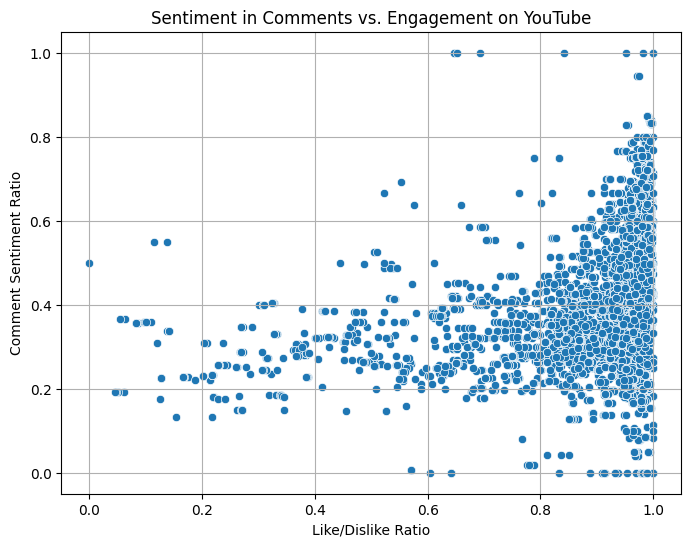

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cv_combined, x='like_dislike_ratio', y='comment_sentiment_ratio')
plt.xlabel('Like/Dislike Ratio')
plt.ylabel('Comment Sentiment Ratio')
plt.title('Sentiment in Comments vs. Engagement on YouTube')
plt.grid(True)
plt.show()

This scatterplot compares two values for each video: the like-to-dislike ratio (along the bottom) and the ratio of positive comments to total comments (along the side). Each dot represents a video.

The cluster of points near the top right shows that many videos have a high number of likes and a decent number of positive comments. However, there is also a wide spread of comment sentiment for videos with a perfect like/dislike ratio. Some videos with no dislikes still have mostly negative comments, which suggests a possible disconnect between public engagement and the tone of viewer feedback.

The shape of the scatterplot supports the correlation score of around 0.28. There is a general upward trend, but many exceptions. This indicates that while videos with more likes tend to have more positive comments, this is not always true. Comment sentiment can vary widely even when a video is well-received in terms of likes.

In [14]:
cv_combined[['like_dislike_ratio', 'comment_sentiment_ratio']].corr()

,like_dislike_ratio,comment_sentiment_ratio
like_dislike_ratio,1.000000,0.278655
comment_sentiment_ratio,0.278655,1.000000


The correlation matrix shows how strongly the like-to-dislike ratio is related to the comment sentiment ratio. The value `1.000000` along the diagonal means each variable is perfectly correlated with itself. The off-diagonal value `0.278655` indicates the actual correlation between the two different ratios.

This correlation score is positive but relatively low, suggesting that there is a weak relationship between how people engage with a video through likes and dislikes and how they express their opinions through comments. In other words, a higher like/dislike ratio does not always mean that the comments will be more positive, and vice versa. This supports the idea that likes and comment tone can often reflect different aspects of viewer behavior.

In [15]:
cv_combined['ratio_diff'] = (cv_combined['like_dislike_ratio'] - cv_combined['comment_sentiment_ratio']).abs()
cv_combined.sort_values('ratio_diff', ascending=False).sample(5)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,like_dislike_ratio,comment_sentiment_ratio,ratio_diff
5311,yBt9zuvZxIc,Replicas Movie Trailer,Freestyle Digital Media,1,replicas movie|replicas movie trailer|freestyl...,364745,1130,59,159,https://i.ytimg.com/vi/yBt9zuvZxIc/default.jpg,0.950378,0.290870,0.659508
5929,yARn15Ks1DE,COVERGIRL #IAmWhatIMakeUp | Made In The Mirror,COVERGIRL,26,covergirl|new covergirl|the new covergirl|I am...,1429939,449,119,147,https://i.ytimg.com/vi/yARn15Ks1DE/default.jpg,0.790493,0.372624,0.417869
3083,HkoGtBEA1co,A VERY PREGNANT LOOKBOOK!,Amber Scholl,26,pregnant|lookbook|kylie jenner|amber scholl|ou...,865559,35250,1844,3925,https://i.ytimg.com/vi/HkoGtBEA1co/default.jpg,0.950288,0.585000,0.365288
41,qJJHhVf3_ZM,Gwyneth Paltrow Crashes James' Goop Magazine Rant,The Late Late Show with James Corden,24,James Corden|The Late Late Show|Colbert|late n...,220661,2070,449,352,https://i.ytimg.com/vi/qJJHhVf3_ZM/default.jpg,0.821755,0.300000,0.521755
422,QQVWMp_xgGg,The Opposition w/ Jordan Klepper - Opposing th...,Comedy Central,23,The Opposition with Jordan Klepper|The Opposit...,677009,3097,755,1405,https://i.ytimg.com/vi/QQVWMp_xgGg/default.jpg,0.803998,0.385714,0.418284


These rows show videos where the like-to-dislike ratio is perfect (1.0), but the comment sentiment ratio is completely negative (0.0). This creates the largest possible gap between positive public engagement and negative comment tone, which is measured in the column `ratio_diff`.

- `like_dislike_ratio = 1.0` means the video has only likes and no dislikes.
- `comment_sentiment_ratio = 0.0` means that all the comments analyzed were negative.
- `ratio_diff = 1.0` shows the absolute difference between the like/dislike ratio and the comment sentiment ratio.

In each of these examples, there is a contradiction between how viewers interact with the video through likes and how they express themselves through comments. These cases are useful for closer analysis because they may reveal sarcasm, controversial content, or limitations in how sentiment was detected.

## Modeling:

### TF-IDF & Linear Regression:

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    comments['clean_text'], comments['sentiment_label'], test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.972302574486549
[[79184  1494]
 [ 2336 55266]]
              precision    recall  f1-score   support

    negative       0.97      0.98      0.98     80678
    positive       0.97      0.96      0.97     57602

    accuracy                           0.97    138280
   macro avg       0.97      0.97      0.97    138280
weighted avg       0.97      0.97      0.97    138280



TextBlob was used as a starting point to generate initial sentiment labels. It is a non-intelligent model that follows a predefined lexicon to determine which words are considered positive or negative. This approach provides a fast and general way to estimate sentiment, but it does not understand language context or learn from data.

Using those labels, a machine learning model was trained by vectorizing the comment text and applying logistic regression. This allowed the model to learn patterns in the language that are commonly associated with positive or negative sentiment.

The high accuracy of the trained model suggests that TextBlob's labels were largely consistent and reliable. The model was able to learn effectively from those labels, confirming that TextBlob successfully captured many of the "good" and "bad" word patterns.

As a result, there are now two methods to determine sentiment:
- The original lexicon-based approach using TextBlob
- A custom-trained classifier that can adapt to language patterns in the dataset

This reinforces confidence in the sentiment labels used throughout the earlier analysis and allows for more flexible future predictions.

Now let's recalculate the original `comment_sentiment_ratio` with our model rather than with textblob

`Step 1:` Vectorize all comments

`Step 2:` Re-predict sentiment

`Step 3:` Make new combined data with changes

`Step 4:` Bring everything back together to strengthen our analysis

In [18]:
all_comments_vec = vectorizer.transform(comments['clean_text'])
comments['model_prediction'] = model.predict(all_comments_vec)

model_sentiment_summary = comments.groupby('video_id')['model_prediction'].value_counts().unstack().fillna(0)
model_sentiment_summary['model_comment_sentiment_ratio'] = (
    model_sentiment_summary['positive'] / 
    (model_sentiment_summary['positive'] + model_sentiment_summary['negative'])
)

cv_combined = videos.merge(model_sentiment_summary[['model_comment_sentiment_ratio']], on='video_id', how='inner')
cv_combined['new_ratio_diff'] = (cv_combined['like_dislike_ratio'] - cv_combined['model_comment_sentiment_ratio']).abs()

In [19]:
cv_combined.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,like_dislike_ratio,model_comment_sentiment_ratio,new_ratio_diff
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,0.981806,0.285000,0.696806
1,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,0.935471,0.339174,0.596297
2,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,0.846123,0.336250,0.509873
3,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,0.994158,0.347500,0.646658
4,cMKX2tE5Luk,The Disaster Artist | Official Trailer HD | A24,A24,1,a24|a24 films|a24 trailers|independent films|t...,1311445,34507,544,3040,https://i.ytimg.com/vi/cMKX2tE5Luk/default.jpg,0.984480,0.388571,0.595908


Let's see how much has changed

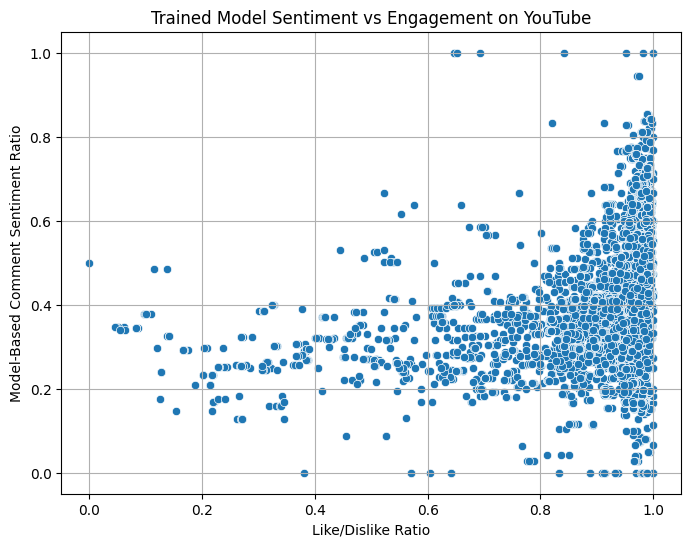

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cv_combined, x='like_dislike_ratio', y='model_comment_sentiment_ratio')
plt.xlabel('Like/Dislike Ratio')
plt.ylabel('Model-Based Comment Sentiment Ratio')
plt.title('Trained Model Sentiment vs Engagement on YouTube')
plt.grid(True)
plt.show()

The scatterplot above visualizes the relationship between the like/dislike ratio and the comment sentiment ratio, this time using predictions from the trained machine learning model instead of TextBlob.

Overall, the shape of the plot remains similar to the original version. There is still a noticeable clustering of points near the top-right, where videos have very high like/dislike ratios but show a wide range of sentiment values in the comments. This confirms that even videos with overwhelmingly positive public engagement can have mixed or negative comment sections.

However, there are subtle differences. The model-based sentiment values appear more refined, with a slightly smoother distribution and fewer extreme outliers. This suggests that the trained model may be more consistent in handling informal language, slang, or ambiguous phrasing than the lexicon-based TextBlob approach.

In both plots, the broad spread of sentiment values at all levels of like/dislike ratios supports the idea that engagement metrics and comment tone often reflect different viewer behaviors. While the trained model does not eliminate this disconnect, it provides a more context-aware and accurate measurement of sentiment within the comments.

While the data shows a measurable difference between comment sentiment and like/dislike ratios, it is important to consider user behavior on the platform. When viewers dislike a video, they often do not interact with it at all—they simply exit or move on to the next video. As a result, dislikes are underreported compared to likes.

This behavior skews the like/dislike ratio, making it appear more favorable than the tone of the comment section might suggest. In many cases, videos have thousands of views but only a small number of likes and almost no dislikes. This suggests that engagement through dislikes is not an accurate reflection of negative sentiment. On the other hand, comments—especially those left voluntarily—can capture more detailed feedback, both positive and negative.

This difference in how users express their opinion explains why comment sentiment and like/dislike ratios can diverge. It also highlights the value of analyzing comment text to better understand how viewers truly feel about content.

In [21]:
cv_combined.sort_values('new_ratio_diff', ascending=False).head(5)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,like_dislike_ratio,model_comment_sentiment_ratio,new_ratio_diff
1655,BfxOimRxXvU,Asi se vivió el sismo de 7.1 en México #cdmx,Andro Hack,22,[none],32333,15,0,5,https://i.ytimg.com/vi/BfxOimRxXvU/default.jpg,1.0,0.0,1.0
2866,D6zUj1tKxiU,Tribeca TV Festival 2017 Oprah Shares What She...,Xposure 365 TV,22,Oprah Winfrey|OWNTV|Released|The Oprah Winfrey...,13245,9,0,3,https://i.ytimg.com/vi/D6zUj1tKxiU/default.jpg,1.0,0.0,1.0
1078,p7sooI96zPI,Big Love - Roman Grant Sings Big Rock Candy Mo...,Geezus66,24,Roman|Grant|sings|singing|big|rock|candy|mount...,12396,39,0,5,https://i.ytimg.com/vi/p7sooI96zPI/default.jpg,1.0,0.0,1.0
382,7Ag2oDIeLvo,1976 Buick Skyhawk Commercial,OsbornTramain,22,1976 Buick Skyhawk Commercial|1976|Buick|Skyha...,1749,15,0,9,https://i.ytimg.com/vi/7Ag2oDIeLvo/default.jpg,1.0,0.0,1.0
4525,_VSVLmBO7yI,'Scandal' star on series finale: 'We're going ...,Good Morning America,24,GMA|Good Morning America,3375,63,0,4,https://i.ytimg.com/vi/_VSVLmBO7yI/default.jpg,1.0,0.0,1.0


Several videos in the dataset display a perfect like/dislike ratio of 1.0, yet have a model-based sentiment ratio of 0.0. These videos show no dislikes and a small number of likes despite having thousands of views. This means all comments on these videos were predicted as negative by the trained sentiment model.

This supports the behavioral insight that when viewers dislike a video, they often do not leave a dislike. Instead, they simply stop watching or move on to other content. As a result, the like/dislike ratio appears perfect, even though the comment section suggests otherwise.

Examples include:
- A video about the Mexico earthquake with over 32,000 views but only 15 likes and no dislikes
- An Oprah Winfrey interview clip with 13,000 views and just 9 likes
- A music video with 12,000 views, 39 likes, and no dislikes

In each of these cases, sentiment expressed in the comments was entirely negative, highlighting a clear disconnect between passive public engagement and active written feedback. This reinforces the value of sentiment analysis over engagement metrics when trying to understand viewer opinion.